In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

import PyComplexHeatmap as pch
from PyComplexHeatmap import *

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi']=300
plt.rcParams['pdf.fonttype']=42

In [2]:
from sklearn.metrics import confusion_matrix
import scipy.cluster.hierarchy as spc

In [3]:
# all options are for different training regiments, I have found that _cs looks / performed best.
# "_b_cs", "_b", "_cs", ""
extension = "_cs" 

In [4]:
# My ordering
cell_types = ['L23_IT_CTX_Glut','L5_ET_CTX_Glut','L6_IT_CTX_Glut','L6_CT_CTX_Glut','CA3_Glut','CA1-ProS_Glut','DG_Glut','Astro-TE_NN','Oligo_NN','OPC_NN',]
# To match RZ's ordering in her plots
cell_types = ['Oligo_NN', 'OPC_NN', 'Astro-TE_NN', 'L23_IT_CTX_Glut', 'L6_IT_CTX_Glut', 'L6_CT_CTX_Glut', 'L5_ET_CTX_Glut', 'CA1-ProS_Glut', 'CA3_Glut', 'DG_Glut']

## Accuracies

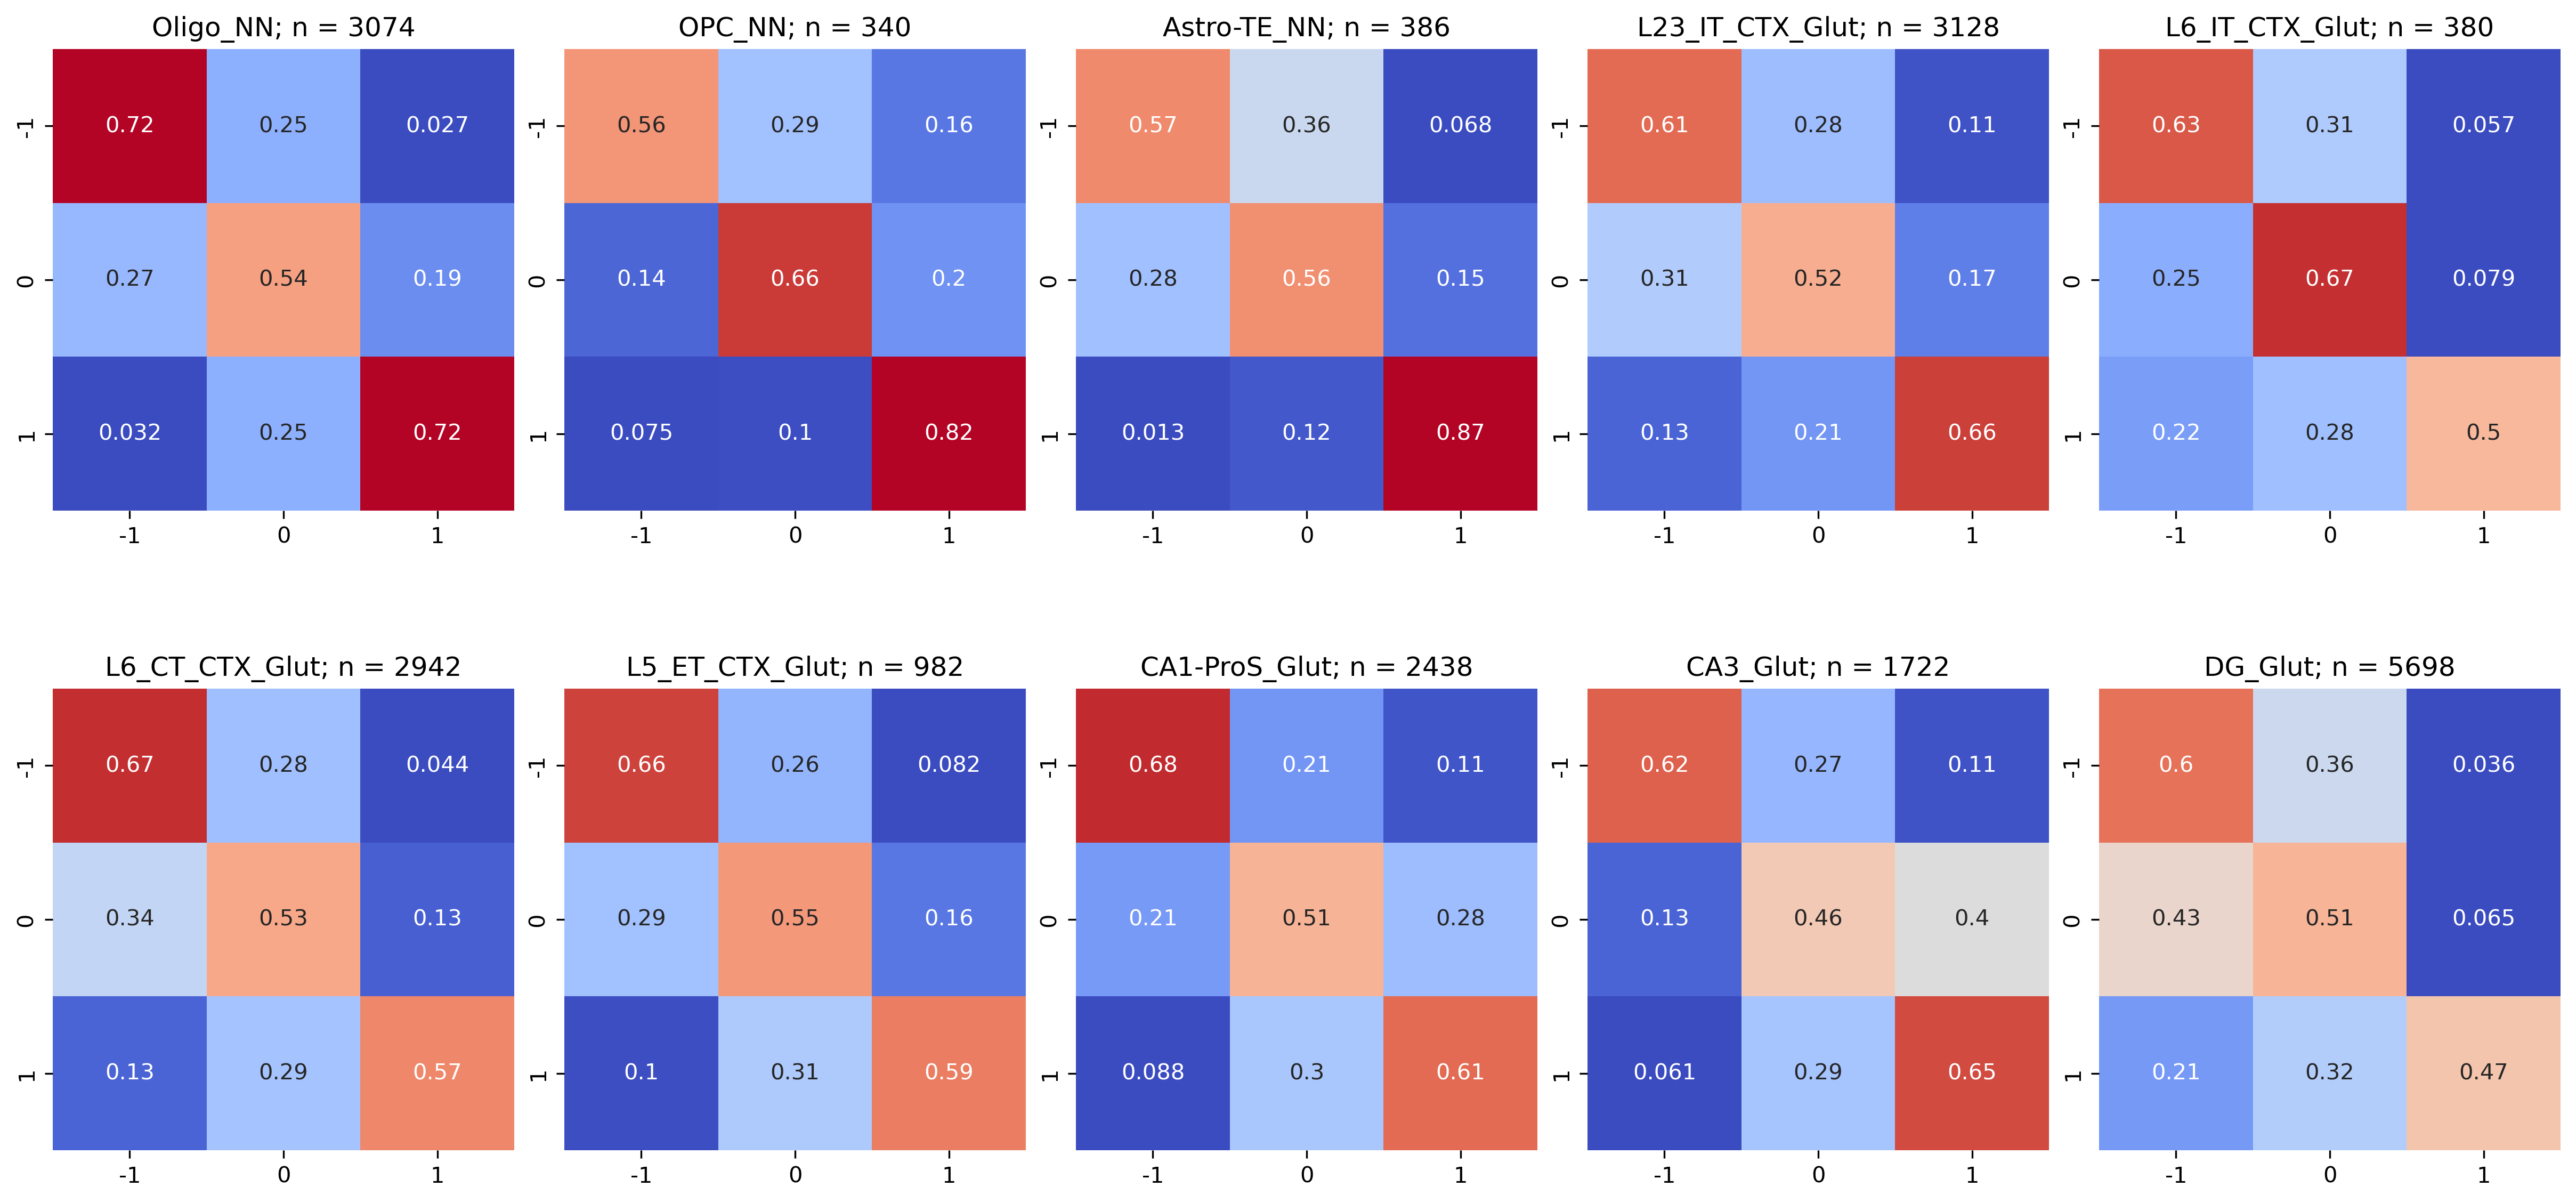

In [5]:
fig, axes = plt.subplots(2, 5, figsize=(16, 8), dpi=300, constrained_layout=True)

for i, _ct in enumerate(cell_types): 
    ax = axes.flatten()[i]
    
    Y_output = pd.read_csv(f"../result_data/xgb_mods/shap_feats/{_ct}.cv{extension}.Y_outs.csv", index_col=0)
    n_sample = Y_output.shape[0]
    
    ccf_test = confusion_matrix(Y_output['DEG'], Y_output['pred'], normalize='true')
    sns.heatmap(ccf_test, vmin=0.1, vmax=0.7, xticklabels = ['-1', '0', '1'], yticklabels = ['-1', '0', '1'], 
                square=True, cmap='coolwarm', annot=True, cbar = False, ax=ax)
    ax.set_title(f"{_ct}; n = {n_sample}")

for i in range(len(cell_types), 10): 
    axes.flatten()[i].remove()

# plt.savefig("../images/xgb_out/model_accuracies_07.pdf", bbox_inches= 'tight')
plt.show()
plt.close()

In [6]:
diag_acc = {}
n_samps = {}
for i, _ct in enumerate(cell_types): 

    Y_output = pd.read_csv(f"../result_data/xgb_mods/shap_feats/{_ct}.cv{extension}.Y_outs.csv", index_col=0)
    n_sample = Y_output.shape[0]
    
    ccf_test = confusion_matrix(Y_output['DEG'], Y_output['pred'], normalize='true')
    diag_acc[_ct] = [ccf_test[0, 0], ccf_test[1, 1], ccf_test[2, 2]]
    n_samps[_ct] = [(Y_output['DEG'] == 0).sum(), (Y_output['DEG'] == 1).sum(), (Y_output['DEG'] == 2).sum()]
    # break
df_diag_acc = pd.DataFrame.from_dict(diag_acc)
df_N = pd.DataFrame.from_dict(n_samps)

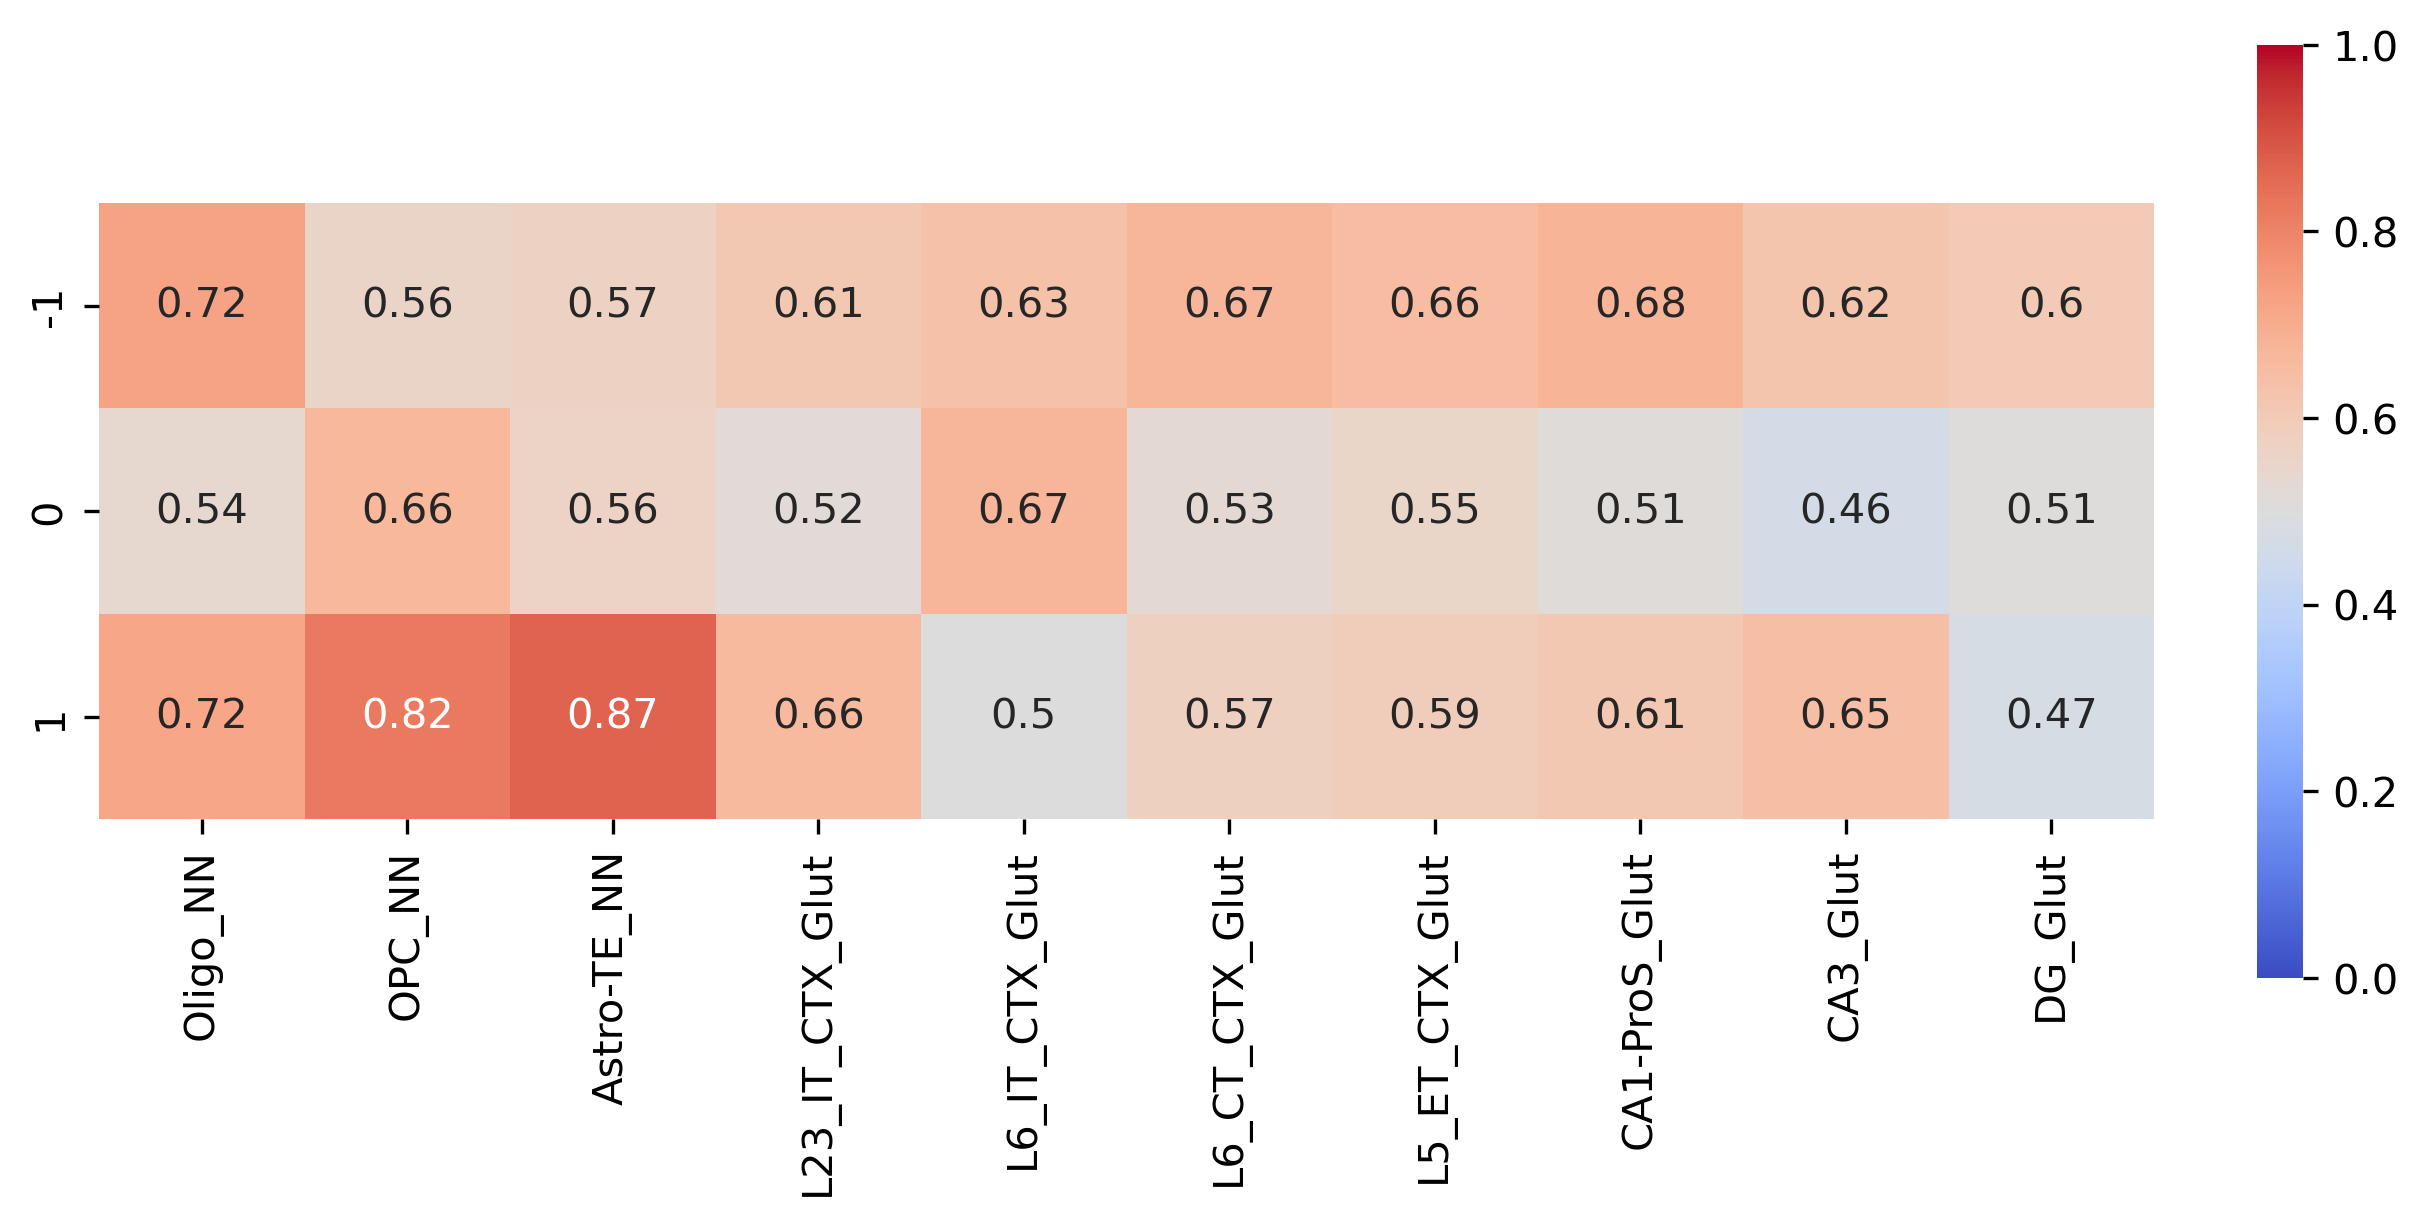

In [7]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=300, constrained_layout=True)
sns.heatmap(df_diag_acc, square=True, cmap='coolwarm', annot=True, vmin=0, vmax=1,
            yticklabels=['-1', '0', '1'], ax=ax)
# plt.savefig("../images/xgb_out/model_accuracies_box_01.pdf", bbox_inches= 'tight')
plt.show()
plt.close()

In [8]:
toplot = df_diag_acc.melt(ignore_index=False).reset_index() # .set_index("variable")
toplot.columns = ['DEG', 'celltype', 'acc']
df_tt = df_N.melt(ignore_index=False).reset_index() # .set_index("variable")
df_tt.columns = ['DEG', 'celltype', 'N']
toplot = toplot.merge(df_tt, on=['DEG', 'celltype'])
toplot['DEG'] = toplot['DEG'].map({0 : "Down", 1 : "Non", 2 : "Up"})

df_row = toplot.groupby('celltype').sum().reset_index()
df_row['NN'] = df_row['celltype'].apply(lambda x: 'NN' if 'NN' in x else 'Glut')
df_row = df_row.set_index('celltype')
df_col = pd.DataFrame({'DEG' : ['Down', 'Non', 'Up']}, index=['Down', 'Non', 'Up'])

/gale/netapp/home2/aklein/miniconda3/envs/agp/lib/python3.10/site-packages/PyComplexHeatmap/dotHeatmap.py:356: FutureWarning: The provided callable <function mean at 0x7f3638202200> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  data2d = data.pivot_table(
/gale/netapp/home2/aklein/miniconda3/envs/agp/lib/python3.10/site-packages/PyComplexHeatmap/dotHeatmap.py:375: FutureWarning: The provided callable <function mean at 0x7f3638202200> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  self.kwargs["s"] = data.pivot_table(
/gale/netapp/home2/aklein/miniconda3/envs/agp/lib/python3.10/site-packages/PyComplexHeatmap/dotHeatmap.py:391: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.kwargs["s"]=self.k

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Inferred max_s (max size of scatter point) is: 432.39075944846013
Plotting legends..
Estimated legend width: 7.5 mm


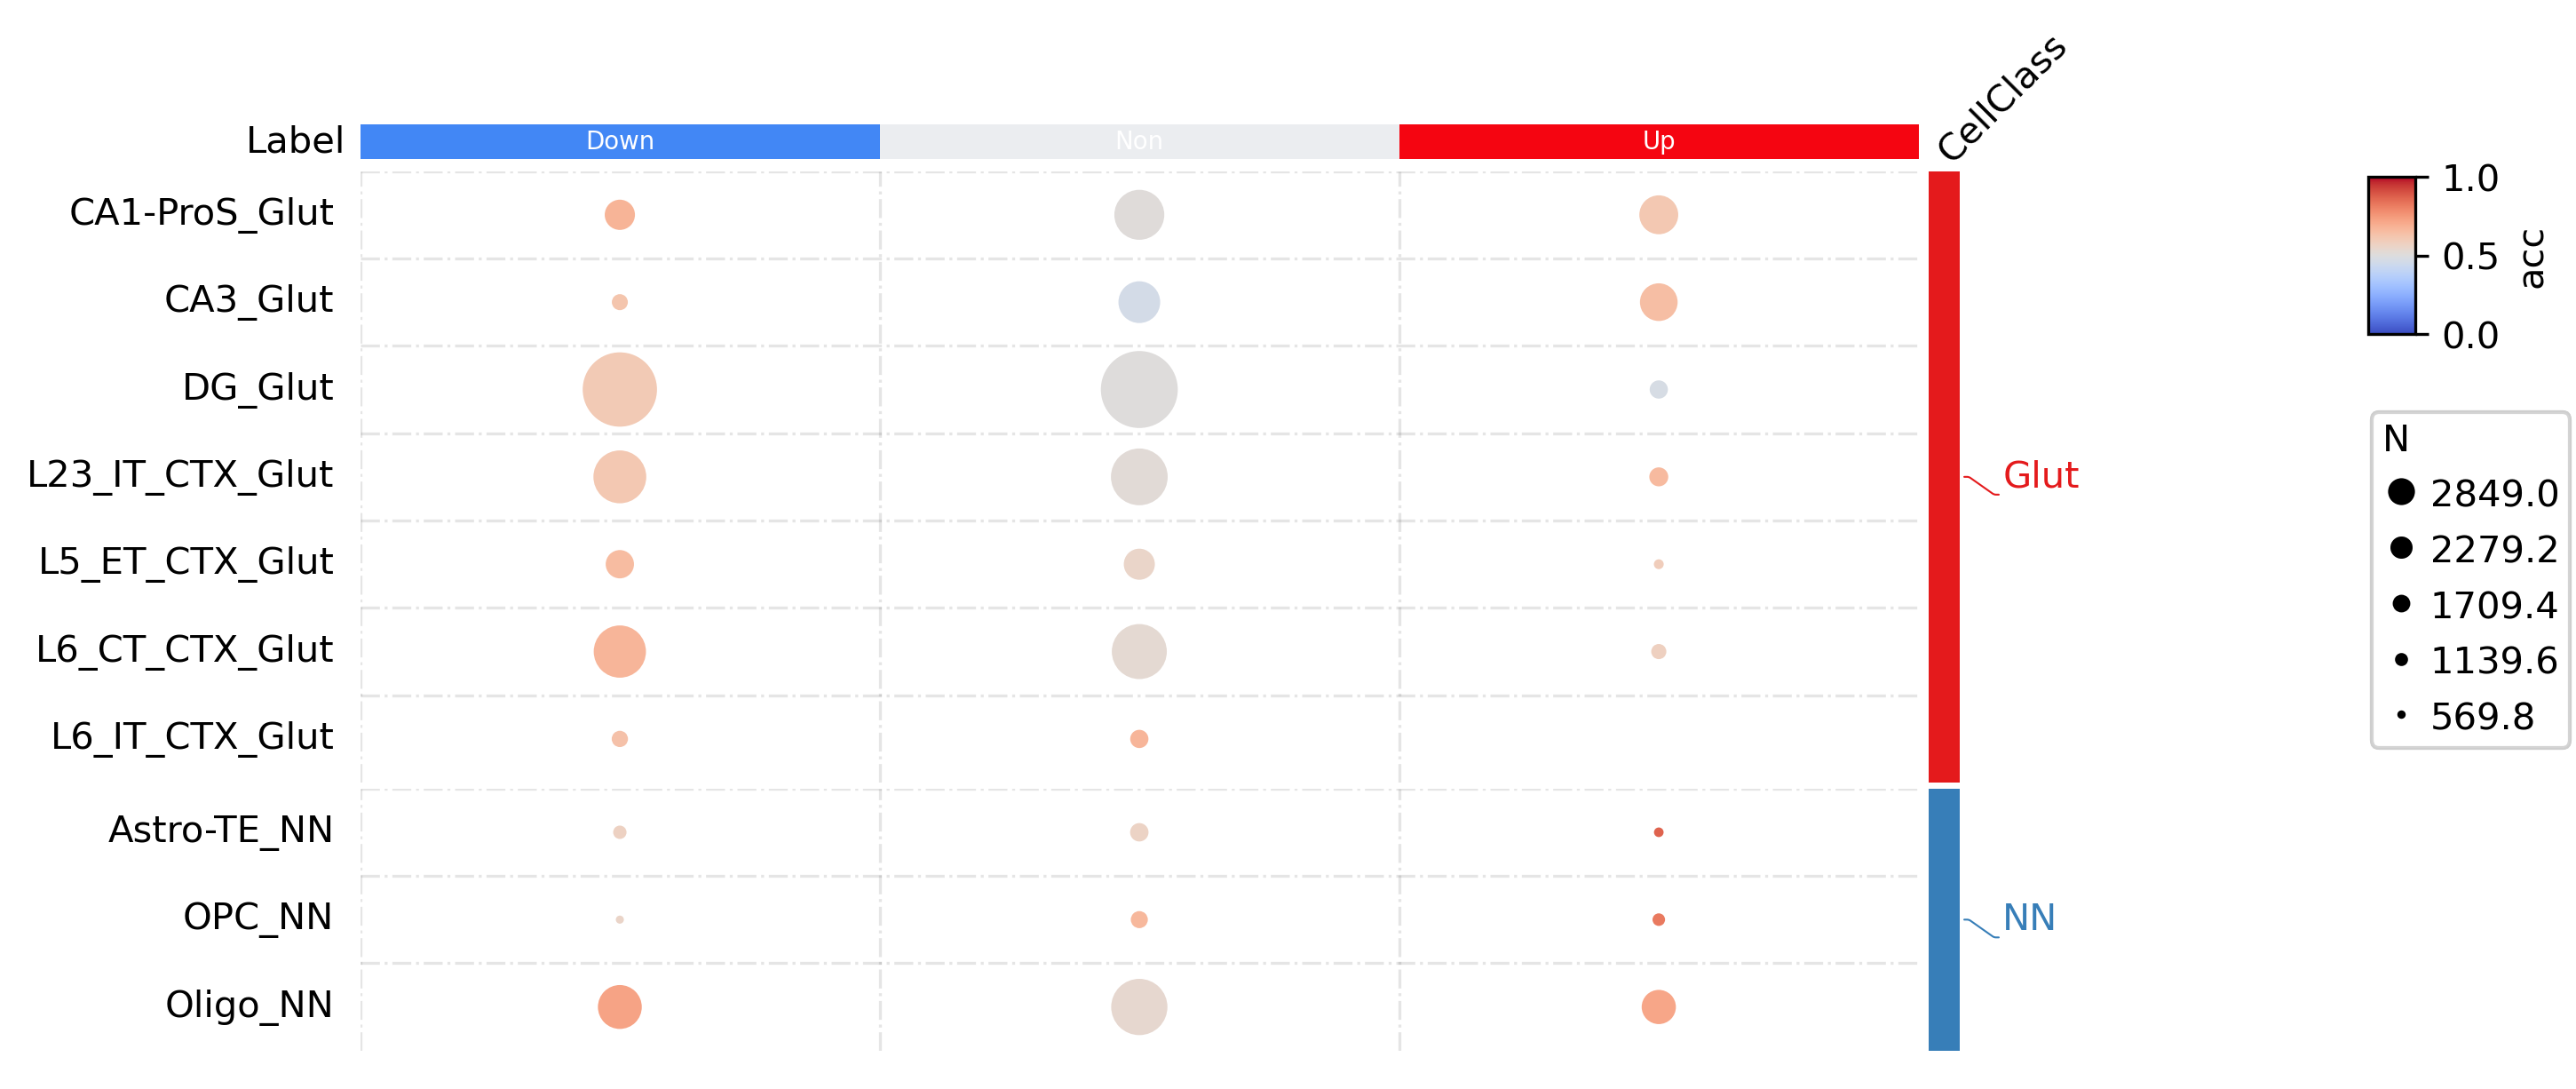

In [21]:
palette = {'Down': '#4287f5', 'Non': '#ebedf0', 'Up': '#f50511'}

row_ha = HeatmapAnnotation(CellClass=anno_simple(df_row.NN, cmap='Set1', add_text=False, legend=False), 
                           label=anno_label(df_row.NN, merge=True, rotation=0), 
                           axis=0, verbose=0, label_kws={'rotation':45, 'horizontalalignment':'left'}
                          )

col_ha = HeatmapAnnotation(Label=anno_simple(df_col.DEG, colors=palette, legend=False, add_text=True), 
                           verbose=0, label_side='left',)

plt.figure(figsize=(8,4), dpi=300)
cm = DotClustermapPlotter(toplot, x='DEG', y='celltype', value='acc', s='N', cmap='coolwarm', 
                          c='acc', vmax=1, vmin=0, linewidth=0, row_split=df_row.NN,
                         show_colnames=False, show_rownames=True, row_cluster=False, alpha=0.3, 
                         right_annotation=row_ha, top_annotation=col_ha)
plt.savefig("../images/xgb_out/model_accuracies_dot_01.pdf", bbox_inches= 'tight')
plt.show()
plt.close()

## Gene x modality

In [34]:
palette = {-1: '#4287f5', 0: '#ebedf0', 1: '#f50511'}
FEATURE_LIST = ['DMR', 'mcg_genebody', 'mch_genebody', 'atac', 'DAR', 'loops', 'enhancer_DMR', 'enhancer_peak'] # , 'meta']
def generate():
    proba = np.random.random()
    max = 0
    for i in range(1,M+1):
         max += (1/2)**i
         if(proba<= max):
              return i-1
    return generate()

In [35]:
with PdfPages(f"../images/xgb_out/geneXmodality_correct.pdf") as pdf:
    
    for i, _ct in enumerate(cell_types): 
        
        shap_list = []
        for _deg, _int_deg in zip(['down', 'non', 'up'], [0, 1, 2]): 
            df_shap = pd.read_csv(f"../result_data/xgb_mods/shap_feats/{_ct}.cv{extension}.shap_{_deg}.csv", index_col=0)
            df_shap = df_shap[(df_shap['DEG'] == df_shap['pred']) & (df_shap['DEG'] == _int_deg)]
            
            stat = df_shap[['DEG', 'pred']]
            df_shap = df_shap[df_shap.columns.difference(['DEG', 'pred'])].T.abs()
            df_shap['modality'] = [idx.split(".")[-1] for idx in df_shap.index]
            # break
            
            df_list = []
            for m in FEATURE_LIST: 
                df_temp = df_shap[df_shap['modality'] == m]
                df_temp = df_temp.drop(columns = ['modality'])
                M = df_temp.shape[0]
                if M == 0: 
                    df_temp = pd.DataFrame(df_shap.columns).set_index("gene_name")
                    df_temp[m] = 0
                    df_list.append(df_temp)
                else: 
                    res = [0 for i in range(M)]
                    for i in range(1000):
                        res[generate()]+=1
                
                    df_temp = df_temp.apply(lambda x: np.average(sorted(x, reverse=True), weights=res), axis=0)
                    df_list.append(pd.DataFrame(df_temp).rename(columns={0:m}))
            # break
        
            df_shap = pd.concat(df_list, axis=1)   
            df_shap = df_shap.apply(lambda x: (x - min(x)) / sum(x - min(x)), axis=1)
            df_shap['DEG'] = stat['DEG']
            shap_list.append(df_shap)
        df_shap = pd.concat(shap_list)
        df_shap['DEG'] = df_shap['DEG'] - 1
    
        # Plotting
        n_samples=df_shap.shape[0]
        toplot = df_shap[['DMR', 'mcg_genebody', 'mch_genebody', 'atac', 'DAR', 'loops', 'enhancer_DMR', 'enhancer_peak']]    
    
        left_ha = pch.HeatmapAnnotation(label = pch.anno_label(df_shap.DEG, merge=True, extend=False, adjust_color=True, luminance=0.75, relpos=(1, 0.5), colors='black'), 
                                        DEG_type = pch.anno_simple(df_shap.DEG, legend=True, colors=palette), 
                                        verbose=1, axis=0, plot_legend=False)
        
        fig = plt.figure(figsize=(5, 6))
        cm = ClusterMapPlotter(
            data = toplot, 
            left_annotation=left_ha,
            show_colnames=True, 
            vmin=0, vmax=0.3, 
            col_cluster=False, row_cluster=False, 
            cmap = 'coolwarm', rasterized=True, 
        )
        plt.suptitle(f"{_ct}: N={n_samples}")
        plt.ylabel("Genes")
        pdf.savefig(dpi=300, bbox_inches='tight')
        plt.close()

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 7.5 mm
Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 7.5 mm
Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 7.5 mm
Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 7.5 mm
Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting cal

In [37]:
with PdfPages(f"../images/xgb_out/geneXmodality_incorrect.pdf") as pdf:

    for i, _ct in enumerate(cell_types): 
    
        shap_list = []
        for _deg, _int_deg in zip(['down', 'non', 'up'], [0, 1, 2]): 
            df_shap = pd.read_csv(f"../result_data/xgb_mods/shap_feats/{_ct}.cv{extension}.shap_{_deg}.csv", index_col=0)
            df_shap = df_shap[(df_shap['DEG'] != df_shap['pred']) & (df_shap['pred'] == _int_deg)]
            
            stat = df_shap[['DEG', 'pred']]
            df_shap = df_shap[df_shap.columns.difference(['DEG', 'pred'])].T.abs()
            df_shap['modality'] = [idx.split(".")[-1] for idx in df_shap.index]
            
            df_list = []
            for m in FEATURE_LIST: 
                df_temp = df_shap[df_shap['modality'] == m]
                df_temp = df_temp.drop(columns = ['modality'])
                M = df_temp.shape[0]
                if M == 0: 
                    df_temp = pd.DataFrame(df_shap.columns).set_index("gene_name")
                    df_temp[m] = 0
                    df_list.append(df_temp)
                else: 
                    res = [0 for i in range(M)]
                    for i in range(1000):
                        res[generate()]+=1
                
                    df_temp = df_temp.apply(lambda x: np.average(sorted(x, reverse=True), weights=res), axis=0)
                    df_list.append(pd.DataFrame(df_temp).rename(columns={0:m}))
            # break
        
            df_shap = pd.concat(df_list, axis=1)   
            df_shap = df_shap.apply(lambda x: (x - min(x)) / sum(x - min(x)), axis=1)
            df_shap['pred'] = stat['pred']
            df_shap['DEG'] = stat['DEG']
            shap_list.append(df_shap)
        df_shap = pd.concat(shap_list)
        df_shap['pred'] = df_shap['pred'] - 1
        df_shap['DEG'] = df_shap['DEG'] - 1
        df_shap = df_shap.sort_values(by=['pred', 'DEG'])
        df_shap = df_shap.loc[~(df_shap.index == 'modality')]
    
        # Plotting
        n_samples=df_shap.shape[0]
        toplot = df_shap[['DMR', 'mcg_genebody', 'mch_genebody', 'atac', 'DAR', 'loops', 'enhancer_DMR', 'enhancer_peak']]    
    
        left_ha = pch.HeatmapAnnotation(label = pch.anno_label(df_shap.pred, merge=True, extend=False, adjust_color=True, luminance=0.75, relpos=(1, 0.5), colors='black'), 
                                        Pred = pch.anno_simple(df_shap.pred, legend=True, colors=palette), 
                                        Label = pch.anno_simple(df_shap.DEG, legend=True, colors=palette), 
                                        verbose=1, axis=0, plot_legend=False)
        
        fig = plt.figure(figsize=(5, 6))
        cm = ClusterMapPlotter(
            data = toplot, 
            left_annotation=left_ha,
            show_colnames=True, 
            vmin=0, vmax=0.3, 
            row_split=df_shap.pred,
            col_cluster=False, row_cluster=False, 
            cmap = 'coolwarm', rasterized=True, 
        )
        plt.suptitle(f"{_ct}: N={n_samples}")
        plt.ylabel("Genes")
        pdf.savefig(dpi=300, bbox_inches='tight')
        plt.close()

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 7.5 mm
Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 7.5 mm
Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 7.5 mm
Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 7.5 mm
Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting cal

## DEG x Modality

In [38]:
FEATURE_LIST = ['DMR', 'mcg_genebody', 'mch_genebody', 'atac', 'DAR', 'loops', 'enhancer_DMR', 'enhancer_peak'] #, 'meta']
FEATURE_MAP = {'DMR' : "mCG_DMR",
               'mcg_genebody' : "mCG_Genebody",
               'mch_genebody' : "mCH_Genebody",
               'atac' : "ATAC",
               'DAR' : "ATAC",
               'loops' : "hic_loops",
               'enhancer_DMR' : "enhancer_DMR",
               'enhancer_peak' : "enhancer_peak"
}
FEAT_ORDER = ["mCG_DMR", "mCG_Genebody", "mCH_Genebody", "ATAC", "hic_loops", "enhancer_DMR", "enhancer_peak"]

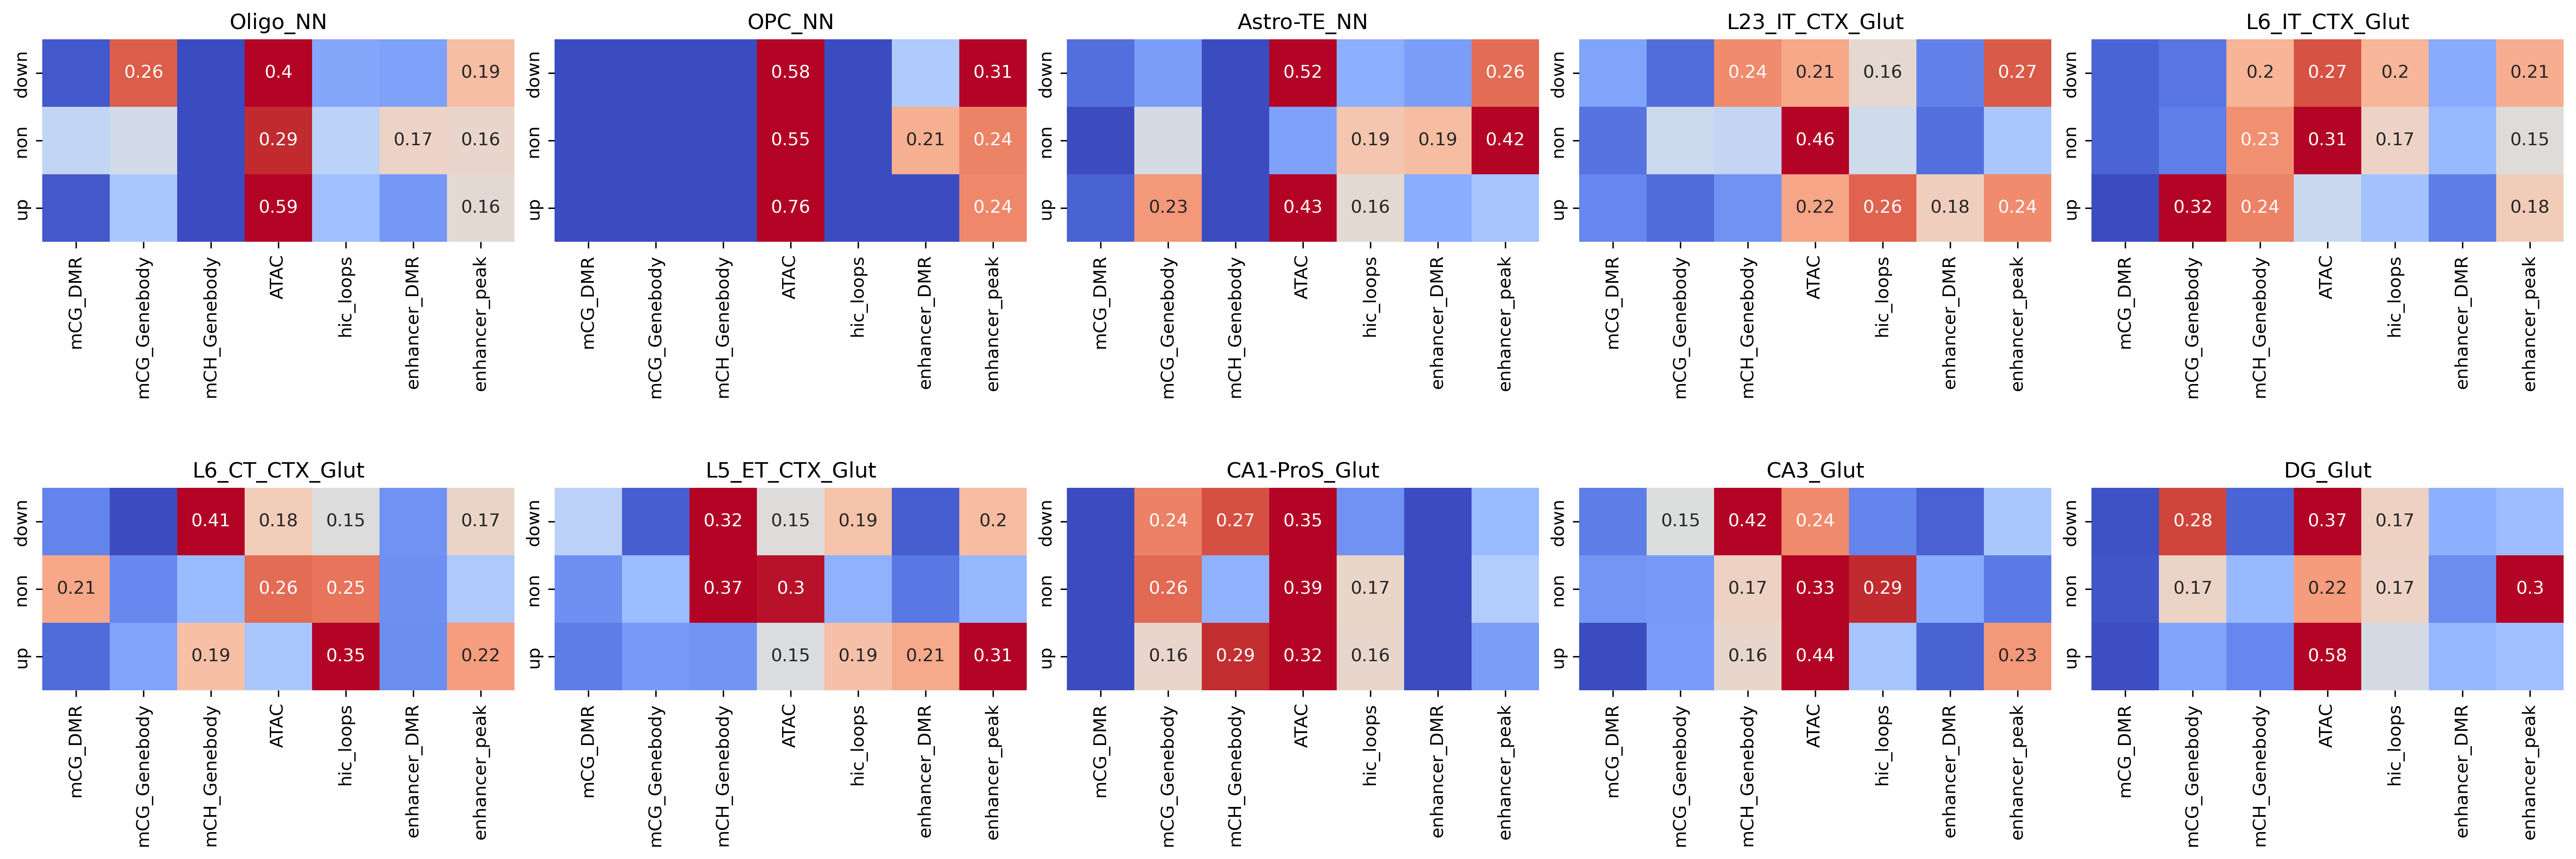

In [42]:
fig, axes = plt.subplots(2, 5, figsize=(20, 7), dpi=300, constrained_layout=True)

CT_RES = {}
for i, _ct in enumerate(cell_types): 
    ax = axes.flatten()[i]
    
    RES = {}
    for _deg, _int_deg in zip(['down', 'non', 'up'], [0, 1, 2]): 
        df_shap = pd.read_csv(f"../result_data/xgb_mods/shap_feats/{_ct}.cv{extension}.shap_{_deg}.csv", index_col=0)
        df_shap = df_shap[(df_shap['DEG'] == df_shap['pred']) & (df_shap['DEG'] == _int_deg)]
        
        stat = df_shap[['DEG', 'pred']]
        df_shap = df_shap[df_shap.columns.difference(['DEG', 'pred'])].T.abs()
        df_shap['modality'] = [idx.split(".")[-1] for idx in df_shap.index]
        df_shap['modality'] = df_shap['modality'].map(FEATURE_MAP)
        # break
        
        df_list = []
        for m in FEAT_ORDER: 
            df_temp = df_shap[df_shap['modality'] == m]
            df_temp = df_temp.drop(columns = ['modality'])
            M = df_temp.shape[0]
            if M == 0: 
                df_temp = pd.DataFrame(df_shap.columns).set_index("gene_name")
                df_temp[m] = 0
                df_list.append(df_temp.T)
            else: 
                res = [0 for i in range(M)]
                for i in range(1000):
                    res[generate()]+=1
            
                df_temp = df_temp.apply(lambda x: np.average(sorted(x, reverse=True), weights=res), axis=0)
                df_list.append(pd.DataFrame(df_temp).rename(columns={0:m}).T)
        # break
    
        df_shap = pd.concat(df_list)    
        # df_shap = df_shap.groupby('modality').mean() # .mean(axis=1)
        df_shap = df_shap.apply(lambda x: (x - min(x)) / sum(x - min(x)), axis=0)
        RES[_deg] = df_shap.mean(axis=1)
    
    CT_RES[_ct] = RES

    sns.heatmap(pd.DataFrame.from_dict(RES).T, square=True, cmap='coolwarm', annot=True, cbar = False, ax=ax, 
                vmin=0, vmax=0.3)
    # setting the annotation only when bigger than some value
    for t in ax.texts:
        if float(t.get_text())>=0.15:
            t.set_text(t.get_text()) #if the value is greater than 0.4 then I set the text 
        else:
            t.set_text("") # if not it sets an empty text
    ax.set_title(f"{_ct}")

for i in range(len(cell_types), 10): 
    axes.flatten()[i].remove()
plt.savefig("../images/xgb_out/degXmodality.pdf", bbox_inches= 'tight')
plt.show()
plt.close()

In [43]:
df_list = []
for _ct, shap_dict in CT_RES.items(): 
    df_mod = pd.DataFrame.from_dict(shap_dict).reset_index().melt(id_vars='index', value_name=_ct)
    df_mod['deg_modality'] = df_mod['variable'] + '_' + df_mod['index']
    df_mod = df_mod.drop(columns = ['variable', 'index']).set_index('deg_modality')
    df_list.append(df_mod)
df_mod = pd.concat(df_list, axis=1)

In [45]:
pdist = spc.distance.pdist(df_mod.T)
linkage = spc.linkage(pdist, method='complete')
idx = spc.fcluster(linkage, 0.5*pdist.max(), 'distance')
columns = [df_mod.columns.tolist()[i] for i in list(np.argsort(idx))]

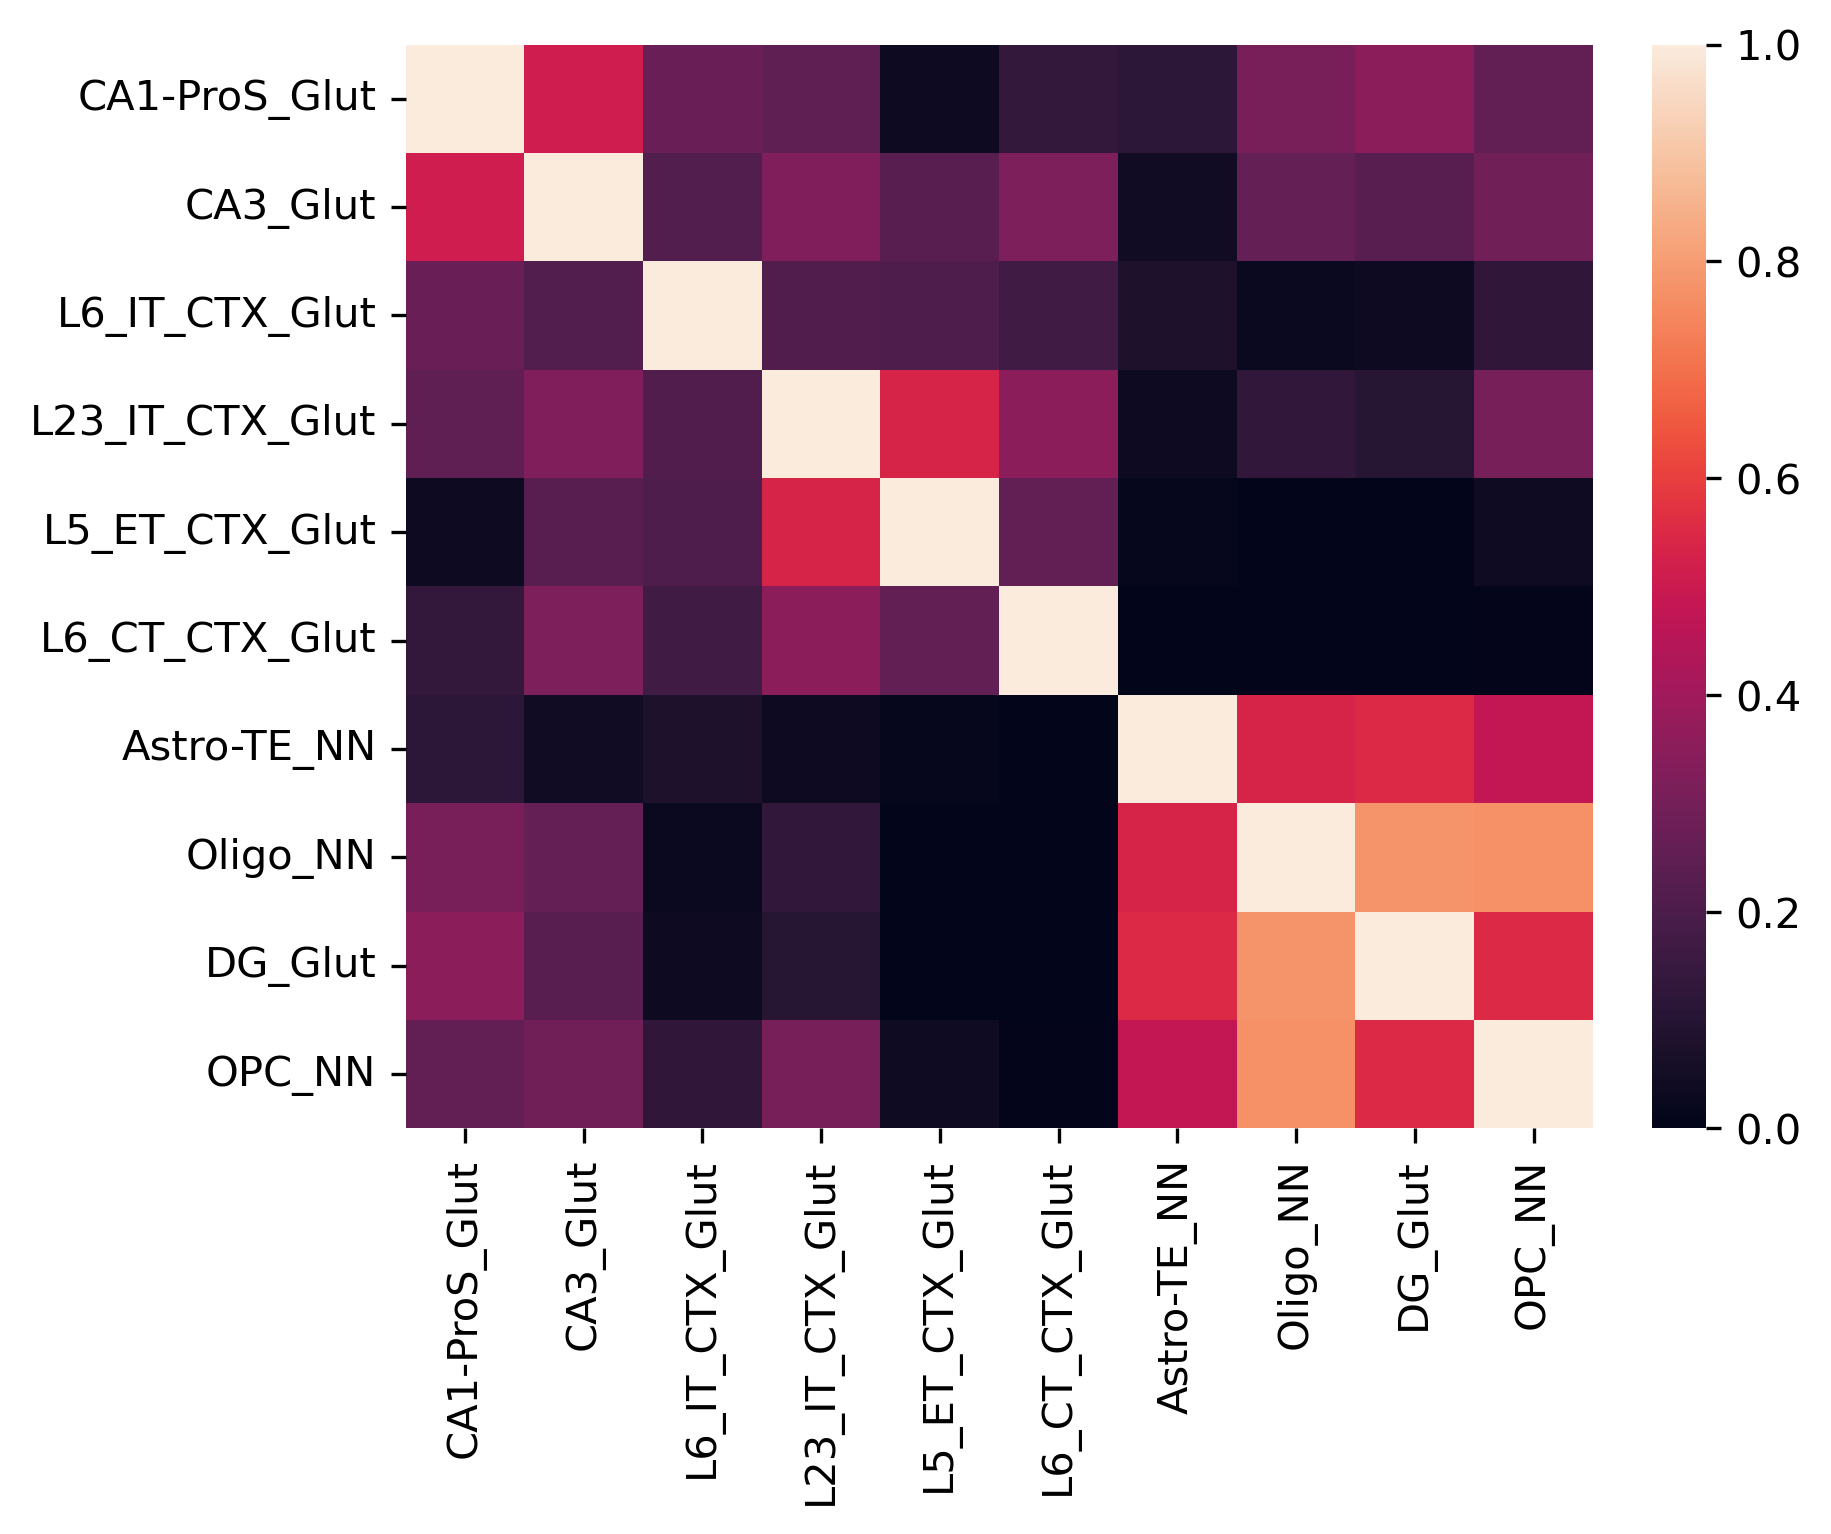

In [47]:
corr_vals = df_mod[columns].corr()
corr_vals = np.power(corr_vals, 2)
plt.figure(figsize=(6, 5), dpi=300, constrained_layout=True)
sns.heatmap(corr_vals, vmin = 0, vmax = 1)
plt.savefig("../images/xgb_out/celltype_corr.pdf", bbox_inches= 'tight')
plt.show()
plt.close()